In [1]:
# Load .env and display model environment variables used by agents
import os
from dotenv import load_dotenv
load_dotenv()
print({k: os.getenv(k) for k in [
    "MODEL_NAME",
    "TEACHER_MODEL",
    "GRADING_MODEL",
    "COORDINATOR_MODEL",
    "STUDENT_MODEL",
    "CRITIQUE_EVAL_MODEL",
]})

{'MODEL_NAME': 'gpt-4o', 'TEACHER_MODEL': 'gpt-5', 'GRADING_MODEL': None, 'COORDINATOR_MODEL': 'gpt-4o', 'STUDENT_MODEL': 'gpt-4o', 'CRITIQUE_EVAL_MODEL': 'gpt-4o-mini'}


In [2]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
from typing_extensions import TypedDict
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib

# Add project root to Python path
project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))

from src.graphs.adaptive_refinement_graph import create_adaptive_refinement_graph, create_initial_state as adaptive_state
from src.graphs.baseline_graph import create_baseline_graph, create_initial_state as baseline_state
from src.utils.gpqa_sampler import create_gpqa_quiz

THRESHOLD = 0.7
MAX_ITERS = 5
BASE_OUT = pathlib.Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

In [3]:
# Run baseline
baseline_graph = create_baseline_graph()

# Run adaptive
adaptive_graph = create_adaptive_refinement_graph()
# adaptive_results = adaptive.invoke(adaptive_state(gpqa_quiz=QUIZ))

In [4]:
# optional: initialize TruLens OpenAI provider to compute simple relevance
try:
    from trulens.providers.openai import OpenAI as TruOpenAI
    tru_provider = TruOpenAI(model_engine="gpt-4o-mini")
except Exception as e:
    tru_provider = None
    print("TruLens provider init failed:", e)

In [5]:
# TruLens LangGraph recorder (logs interactions)
try:
    from trulens.core.database.connector.default import DefaultDBConnector
    from trulens.core.session import TruSession
    from trulens.apps.langgraph import TruGraph

    connector = DefaultDBConnector(database_url="sqlite:///edu_refine.sqlite")
    tru_session = TruSession(connector=connector)

    # Recorder for adaptive refinement graph
    tru_recorder = TruGraph(adaptive_graph, app_name="Educational Refinement Agent", app_version="mvp-adaptive")

    # Recorder for baseline graph
    tru_baseline_recorder = TruGraph(baseline_graph, app_name="Educational Refinement Agent", app_version="mvp-baseline")
except Exception as e:
    tru_recorder = None
    tru_baseline_recorder = None
    print("TruGraph init failed:", e)

🦑 Initialized with db url sqlite:///edu_refine.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
✅ experimental Feature.OTEL_TRACING enabled.
🔒 experimental Feature.OTEL_TRACING is enabled and cannot be changed.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <c

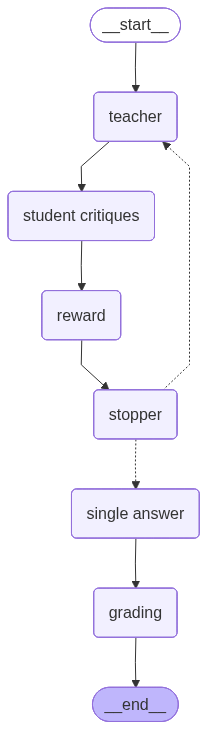

In [6]:
from IPython.display import Image

display(Image(adaptive_graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {
    "gpqa_question": quiz[0],
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": []
}

if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})

# Build results dict (single-answer evaluation)
results = {
    "dataset": "GPQA",
    "subset": locals().get("subset", "gpqa_main"),
    "domain": locals().get("domain", "Physics"),
    "gpqa_index": locals().get("idx", None),
    "record_id": state.get("gpqa_question", {}).get("id"),
    "question": state.get("gpqa_question", {}).get("question", ""),
    "iterations": state.get("iteration", 0),
    "final_scores": state.get("reward_scores", {}),
    "final_explanation": state.get("explanation", ""),
    "history": state.get("history", []),
    "gpqa_question": state.get("gpqa_question", {}),
    "single_answer": state.get("single_answer", ""),
    "single_explanation": state.get("single_explanation", ""),
    "quiz_results": state.get("quiz_results", {}),
}

print("Dataset:", results["dataset"], results["subset"], results["domain"]) 
print("Record ID:", results["record_id"]) 
print("Question:", results["question"]) 
print("Iterations:", results["iterations"]) 
print("Final scores:", results["final_scores"]) 
print("\nFinal explanation (truncated to 800 chars):\n")
print(results["final_explanation"][:800])

# Print question block
qobj = results.get("gpqa_question", {})
if qobj:
    print("\nGPQA Question:")
    print(f"- ID: {qobj.get('id','')}")
    print(f"  Stem: {qobj.get('question','').strip()}")
    for opt in qobj.get("options", []):
        print(f"  {opt}")
    print(f"  Correct: {qobj.get('correct','?')}")

# Single answer and explanation
print("\nSingle Answer Evaluation:")
print(f"- Predicted: {results.get('single_answer','?')}")
print(f"- One-sentence explanation: {results.get('single_explanation','')}")

quiz_results = results.get("quiz_results", {})
if quiz_results:
    print("\nQuiz Results:")
    print(f"- Correct: {quiz_results.get('is_correct', False)}")
    sim = quiz_results.get("explanation_similarity", 0.0)
    print(f"- Explanation similarity: {sim*100:.1f}%")

# Persist results to results/ with timestamped filename
_ts = datetime.now().strftime("%Y%m%d_%H%M%S")

def _slugify(s: str, limit: int = 40) -> str:
    s = (s or "").strip()
    slug = "".join(ch if ch.isalnum() else "_" for ch in s)
    return slug[:limit] if limit > 0 else slug

_id_part = results.get("record_id") or _slugify(results["question"]) or "run"
outfile = BASE_OUT / f"run_{_ts}_{_id_part}.json"
record = {
    "timestamp": _ts,
    "dataset": results["dataset"],
    "subset": results["subset"],
    "domain": results["domain"],
    "gpqa_index": results.get("gpqa_index"),
    "record_id": results.get("record_id"),
    "question": results["question"],
    "final_explanation": results["final_explanation"],
    "iterations": results["iterations"],
    "final_scores": results["final_scores"],
    "gpqa_question": results.get("gpqa_question", {}),
    "single_answer": results.get("single_answer", ""),
    "single_explanation": results.get("single_explanation", ""),
    "quiz_results": results.get("quiz_results", {}),
}
outfile.write_text(json.dumps(record, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"\nSaved results to: {outfile}")

C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loaded 187 Physics questions from gpqa_main
Dataset: GPQA gpqa_main Physics
Record ID: recvlnu8BuLmXZhSX
Question: The state of a system at time t is given by the column matrix having elements (-1, 2, 1). An observable of the system is represented by the matrix operator P having elements in the first row as (0, 1/ \sqrt{2}, 0),  in the second row as (1/ \sqrt{2}, 0, 1/ \sqrt{2}) and in the third row as (0, 1/ \sqrt{2}, 0). Calculate the probability that the measurement of the observable will yield 0 at time t.
Topics: Understanding state vectors and column matrices, Introduction to observable operators in quantum mechanics, Matrix multiplication and its relevance in quantum measurements, Calculating probabilities from measurement operators, Eigenvalues and eigenvectors of observable matri

In [7]:
# launch TruLens dashboard to view agent interactions
from trulens.dashboard import run_dashboard
run_dashboard()  # prints a local URL (e.g., http://localhost:8501); open it in your browser

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://localhost:57355 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

In [8]:
# Baseline batch run: 20 Physics questions (progress + JSON)
import json
import time
from datetime import datetime
from pathlib import Path
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

subset = "gpqa_main"
domain = "Physics"
seed = 100
num_questions = 20
# Per-question delay (seconds) to avoid rate limits
delay_secs = 10

quiz, indices = create_gpqa_quiz(subset=subset, domain=domain, seed=seed, num_questions=num_questions)

try:
    _bg = baseline_graph  # type: ignore[name-defined]
except Exception:
    _bg = create_baseline_graph()

rows = []

# If TruLens baseline recorder is available, wrap the loop so each invoke is traced
if 'tru_baseline_recorder' in globals() and tru_baseline_recorder is not None:
    context_manager = tru_baseline_recorder
else:
    from contextlib import nullcontext
    context_manager = nullcontext()

with context_manager as recording:
    for q in tqdm(quiz, total=len(quiz), desc="Baseline (Physics)"):
        init = baseline_state(gpqa_question=q, threshold=THRESHOLD, max_iters=1)
        state = _bg.invoke(init, config={"recursion_limit": 10})
        gpqa_q = state.get("gpqa_question", {})
        quiz_res = state.get("quiz_results", {}) or {}

        # correct letter and option text
        correct_letter = str(gpqa_q.get("correct", "")).strip().upper()
        correct_text = ""
        opts = [str(x) for x in (gpqa_q.get("options", []) or [])]
        if correct_letter in {"A","B","C","D"}:
            for opt in opts:
                if len(opt) >= 2 and opt[0].upper() == correct_letter:
                    correct_text = opt[2:].strip() if len(opt) > 2 else ""
                    break

        rows.append({
            "id": gpqa_q.get("id"),
            "question": gpqa_q.get("question", ""),
            "correct": correct_letter,
            "correct_text": correct_text,
            "teacher_explanation": state.get("explanation", ""),
            "llm_answer": state.get("single_answer", ""),
            "llm_one_sentence": state.get("single_explanation", ""),
            "similarity": quiz_res.get("explanation_similarity", 0.0),
            "is_correct": bool(quiz_res.get("is_correct", False)),
        })

        # Wait between requests to avoid rate limits
        time.sleep(delay_secs)

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"baseline_batch_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)
outfile.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Saved {len(rows)} results to {outfile}")

Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 187 Physics questions from gpqa_main


Baseline (Physics):   0%|          | 0/20 [00:00<?, ?it/s]

Saved 20 results to results\baseline_batch_20251115_172542.json


In [ ]:
# Adaptive batch run: 20 Physics questions (progress + JSON)
import json
import time
from datetime import datetime
from pathlib import Path
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm import tqdm

subset = "gpqa_main"
domain = "Physics"
seed = 100
num_questions = 20
# Per-question delay (seconds) to avoid rate limits
delay_secs = 10

quiz, indices = create_gpqa_quiz(subset=subset, domain=domain, seed=seed, num_questions=num_questions)

try:
    _ag = adaptive_graph  # type: ignore[name-defined]
except Exception:
    _ag = create_adaptive_refinement_graph()

rows = []

# If TruLens adaptive recorder is available, wrap the loop so each invoke is traced
if 'tru_recorder' in globals() and tru_recorder is not None:
    context_manager = tru_recorder
else:
    from contextlib import nullcontext
    context_manager = nullcontext()

with context_manager as recording:
    for q in tqdm(quiz, total=len(quiz), desc="Adaptive (Physics)"):
        init = adaptive_state(gpqa_question=q, threshold=THRESHOLD, max_iters=MAX_ITERS)
        state = _ag.invoke(init, config={"recursion_limit": 30})
        gpqa_q = state.get("gpqa_question", {})
        quiz_res = state.get("quiz_results", {}) or {}

        # correct letter and option text
        correct_letter = str(gpqa_q.get("correct", "")).strip().upper()
        correct_text = ""
        opts = [str(x) for x in (gpqa_q.get("options", []) or [])]
        if correct_letter in {"A","B","C","D"}:
            for opt in opts:
                if len(opt) >= 2 and opt[0].upper() == correct_letter:
                    correct_text = opt[2:].strip() if len(opt) > 2 else ""
                    break

        rows.append({
            "id": gpqa_q.get("id"),
            "question": gpqa_q.get("question", ""),
            "correct": correct_letter,
            "correct_text": correct_text,
            "teacher_explanation": state.get("explanation", ""),
            "llm_answer": state.get("single_answer", ""),
            "llm_one_sentence": state.get("single_explanation", ""),
            "similarity": quiz_res.get("explanation_similarity", 0.0),
            "is_correct": bool(quiz_res.get("is_correct", False)),
        })

        # Wait between requests to avoid rate limits
        time.sleep(delay_secs)

_ts = datetime.now().strftime("%Y%m%d_%H%M%S")
outfile = Path("results") / f"adaptive_batch_{_ts}.json"
outfile.parent.mkdir(parents=True, exist_ok=True)
outfile.write_text(json.dumps(rows, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"Saved {len(rows)} results to {outfile}")